In [1]:
import sys
from source_data import Requests
import pandas as pd
import numpy as np
import contextily as cx
import geopandas as gpd
from shapely.geometry import Point,LineString
import matplotlib.pyplot as plt
import seaborn as sns
import os
OUT_FOLDER = r'output_logs'

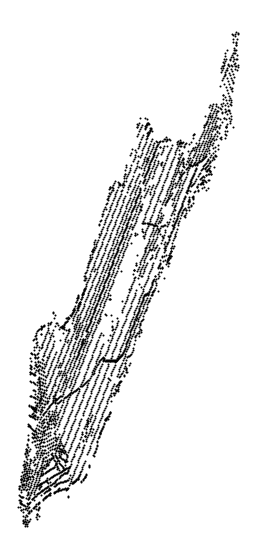

In [2]:
# get the nyc intersection positions
intersections = pd.read_csv(r'datasets/ny_intersections.csv')
intersections.head()

# create a bunch of points
inter_points = [dict(node=i,geometry=Point(x,y))
                for i,x,y in intersections.to_records()]
intersections = gpd.GeoDataFrame(inter_points,crs='EPSG:4326')# .to_crs(epsg=3857)
# intersections.head()

# plot the intersections
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax = intersections.plot(color='black',markersize=1,ax=ax)
plt.axis('off')
plt.savefig("intersection_map.jpg")

In [3]:
# get the model output logs
out_logs = []
for fnm in os.listdir(OUT_FOLDER):
    print(fnm)
    out_logs.append(pd.read_csv(os.path.join(OUT_FOLDER,fnm),dtype=dict(passenger_id=int)))

# concatenate them together
out_df = pd.concat(out_logs)
out_df.head()

0_0.csv


,time_stamp,passenger_id,cab_id,event,location
0,39,74,v15,pickup,185
1,52,121,v25,pickup,318
2,30,20,v26,pickup,662
3,35,10,v29,pickup,420
4,46,182,v30,pickup,1231


Check the passengers are only picked up and dropped off once:
- so passengers are being picked up and dropped off more than once.
- suspect there is something wrong with the booking system - when existing passengers are re-routed

In [4]:
np.unique((out_df['passenger_id'].astype(str)+" "+out_df['event']).value_counts().values)

array([1])

In [5]:
# print out the time range
out_df.describe()

,time_stamp,passenger_id,location
count,39153.000000,39153.000000,39153.000000
mean,1827.722601,10111.377825,1461.536025
std,979.498911,6045.505554,809.966530
min,30.000000,0.000000,2.000000
25%,1014.000000,4934.000000,870.000000
50%,1801.000000,9885.000000,1349.000000
75%,2645.000000,15025.000000,1953.000000
max,3600.000000,22602.000000,4074.000000


In [6]:
# get the requests in the first hour
reqs = Requests().read_requests()
reqs = reqs[reqs['time']<3600]
reqs.head()

,time,from_node,to_node,window,day,hour,latest_pickup
0,0,1167,1956,0,0,0,120
1,0,1669,1243,0,0,0,120
2,0,1609,1632,0,0,0,120
3,0,1092,910,0,0,0,120
4,0,1278,867,0,0,0,120


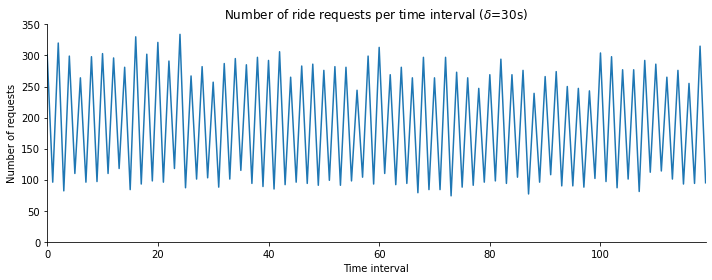

In [7]:
# summarise the requests by hour
numreqs_by_window = reqs.groupby(['window']).agg('count')['time'].rename("num_requests")

# count the number of request picked up in each window
fig,ax = plt.subplots(figsize=[10,4])
numreqs_by_window.plot()
ax.set_title("Number of ride requests per time interval ($\delta$=30s)")
ax.set_ylabel("Number of requests")
ax.set_xlabel("Time interval")
ax.set_ylim([0,350])
ax.set_xlim([0,119])
sns.despine()
fig.tight_layout()
plt.savefig(r"results/numrequests.jpg")

In [8]:
# count the number of picked up picked up requests
# but remove the duplicate pickups
clean_pickups = out_df.groupby(['passenger_id']).apply(lambda x: x.sort_values(['time_stamp']).iloc[0]).reset_index(drop=True)
assert clean_pickups['event'].value_counts().values[0] == len(out_df['passenger_id'].unique())

In [9]:
# get the timewindows for the pickups
pickups = clean_pickups.join(reqs.loc[:,'window'],on=['passenger_id'])
numpicks_by_window = pickups.groupby(['window']).agg('count')['time_stamp'].rename("num_pickups")

# stick it all together
result = pd.concat([numreqs_by_window,numpicks_by_window],axis=1)
result.head()

,num_requests,num_pickups
window,,
0,301,300.0
1,96,96.0
2,320,320.0
3,82,82.0
4,299,299.0


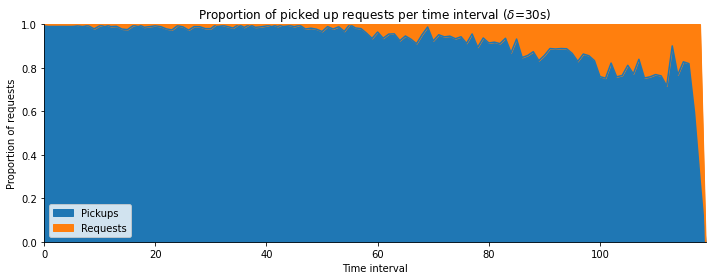

In [10]:
# need to convert to proportion
proportion = result.copy()
proportion['Pickups'] = proportion['num_pickups'] / proportion['num_requests']
proportion['Requests'] = 1 - proportion['Pickups']

# plot proportion of requests that are picked up
fig,ax = plt.subplots(figsize=[10,4])
ax = proportion.loc[:,['Pickups','Requests']].plot.area(ax=ax)

# format the plot
ax.set_xlabel("Time interval")
ax.set_ylabel("Proportion of requests")
ax.set_title("Proportion of picked up requests per time interval ($\delta$=30s)")
ax.set_xlim([0,119])
ax.set_ylim([0,1])
sns.despine()
fig.tight_layout()
plt.savefig(r"results/proportion.jpg")

In [11]:
# finally show the cab utilisation
cab_use = []
time_index = pd.Series(list(range(0,3600)),name="time_index")
for cab,data in out_df.groupby(['cab_id']):
    
    state = data.copy().sort_values(['time_stamp'])
    state['change'] = data['event'].copy().map(lambda x: 1 if x == 'pickup' else -1)
    state['capacity'] = np.cumsum(state['change'])
    
    # add all time to the cab
    state = state.join(time_index,on=['time_stamp'],how='right').iloc[:,[0,2,6]]#.set_index(['time_stamp'])
    
    # if the capacity at time 0 is na then set it to 0
    if state['capacity'].isnull().iloc[0]:
        state.iloc[0,1] = cab
        state.iloc[0,2] = 0
        
    
    # now fill down to the next state change
    state = state.fillna(method='ffill')
    state['utilised'] = state['capacity'].map(lambda x: 1 if x > 0 else 0)
#     print(state.head())
    cab_use.append(state)

# join it all together
cab_use = pd.concat(cab_use).reset_index(drop=True)
cab_use.head()

,time_stamp,cab_id,capacity,utilised
0,0,v0,0.0,0
1,1,v0,0.0,0
2,2,v0,0.0,0
3,3,v0,0.0,0
4,4,v0,0.0,0


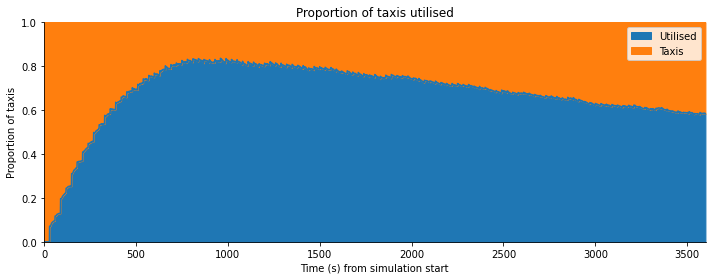

In [12]:
# now count utilised by time
utilised_count = cab_use.groupby(['time_stamp'])['utilised'].agg(['sum']).reset_index(drop=True)

# now caculate the proportion utilised
proportion_utilised = utilised_count / 3000
diff_utilised = 1 - proportion_utilised
to_plot = pd.concat([proportion_utilised,diff_utilised],axis=1)
to_plot.columns = ["Utilised","Taxis"]

# plot proportion of requests that are picked up
fig,ax = plt.subplots(figsize=[10,4])
ax = to_plot.plot.area(ax=ax)

# format the plot
ax.set_xlabel("Time (s) from simulation start")
ax.set_ylabel("Proportion of taxis")
ax.set_title("Proportion of taxis utilised")
ax.set_xlim([0,3600])
ax.set_ylim([0,1])
sns.despine()
fig.tight_layout()
plt.savefig(r"results/proportion_cabs.jpg")

In [13]:
# interesting cab = v740
focus = 'v740'

# follow a cap that doesn't have lots of errors
cab_data = out_df.groupby(['cab_id'])
# for cab,data in cab_data:
    
#     # count pickups and drop offs
#     picks_drops = (data['passenger_id'].astype(str)+
#                    " "+data['event']).value_counts()
#     if picks_drops.values[0] == 1:
        
#         print(data)
to_focus = cab_data.get_group('v740')
to_focus

,time_stamp,passenger_id,cab_id,event,location
871,150,861,v740,pickup,1562
4976,622,861,v740,dropoff,2877
9580,990,6573,v740,pickup,2989
19991,1847,11895,v740,pickup,307
20766,1907,6573,v740,dropoff,359
26985,2455,15466,v740,pickup,355
28723,2594,11895,v740,dropoff,207
29988,2711,16645,v740,pickup,314
32849,2997,15466,v740,dropoff,1055
33779,3083,19206,v740,pickup,1248


In [14]:
# check the capacity of the cab
state = to_focus.copy()
state['change'] = to_focus['event'].copy().map(lambda x: 1 if x == 'pickup' else -1)
state['capacity'] = np.cumsum(state['change'])
state

,time_stamp,passenger_id,cab_id,event,location,change,capacity
871,150,861,v740,pickup,1562,1,1
4976,622,861,v740,dropoff,2877,-1,0
9580,990,6573,v740,pickup,2989,1,1
19991,1847,11895,v740,pickup,307,1,2
20766,1907,6573,v740,dropoff,359,-1,1
26985,2455,15466,v740,pickup,355,1,2
28723,2594,11895,v740,dropoff,207,-1,1
29988,2711,16645,v740,pickup,314,1,2
32849,2997,15466,v740,dropoff,1055,-1,1
33779,3083,19206,v740,pickup,1248,1,2
